In [1]:
# For example, here's several helpful packages to load

import numpy as np # linear algebra

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
## for data

import re
import nltk  ## for language detection



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
df = pd.read_csv('/content/justice.csv', delimiter=',', encoding = 'utf8')
df.dropna(inplace=True)
df.head()

,Unnamed: 0,ID,name,href,docket,term,first_party,second_party,facts,facts_len,majority_vote,minority_vote,first_party_winner,decision_type,disposition,issue_area
1,1,50613,Stanley v. Illinois,https://api.oyez.org/cases/1971/70-5014,70-5014,1971,"Peter Stanley, Sr.",Illinois,<p>Joan Stanley had three children with Peter ...,757,5,2,True,majority opinion,reversed/remanded,Civil Rights
2,2,50623,Giglio v. United States,https://api.oyez.org/cases/1971/70-29,70-29,1971,John Giglio,United States,<p>John Giglio was convicted of passing forged...,495,7,0,True,majority opinion,reversed/remanded,Due Process
3,3,50632,Reed v. Reed,https://api.oyez.org/cases/1971/70-4,70-4,1971,Sally Reed,Cecil Reed,"<p>The Idaho Probate Code specified that ""male...",378,7,0,True,majority opinion,reversed/remanded,Civil Rights
4,4,50643,Miller v. California,https://api.oyez.org/cases/1971/70-73,70-73,1971,Marvin Miller,California,"<p>Miller, after conducting a mass mailing cam...",305,5,4,True,majority opinion,vacated/remanded,First Amendment
5,5,50644,Kleindienst v. Mandel,https://api.oyez.org/cases/1971/71-16,71-16,1971,"Richard G. Kleindienst, Attorney General of th...","Ernest E. Mandel, et al.",<p>Ernest E. Mandel was a Belgian professional...,2282,6,3,True,majority opinion,reversed,First Amendment


In [3]:
df1 = df.copy()


In [4]:
df1.drop(columns=['Unnamed: 0', 'docket','name','first_party','second_party', 'issue_area',
                 'facts_len', 'majority_vote', 'minority_vote', 'href', 'ID','term'], inplace=True)

In [5]:
df_cat = df1[['decision_type', 'disposition']]


In [6]:
df_target = df1['first_party_winner']

In [7]:
df_nlp = df1['facts']


In [8]:
df_cat.reset_index(drop=True, inplace=True)
df_target.reset_index(drop=True, inplace=True)
df_nlp.reset_index(drop=True, inplace=True)

In [9]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df_target= label_encoder.fit_transform(df_target)

In [10]:
df_target1 = pd.DataFrame(df_target, columns=['first_party_winner'])
df_target1

,first_party_winner
0,1
1,1
2,1
3,1
4,1
...,...
3093,1
3094,1
3095,0
3096,1


In [11]:
frames = [df_cat, df_target1]
df_concat = pd.concat(frames, axis=1, join='inner')
df_concat

,decision_type,disposition,first_party_winner
0,majority opinion,reversed/remanded,1
1,majority opinion,reversed/remanded,1
2,majority opinion,reversed/remanded,1
3,majority opinion,vacated/remanded,1
4,majority opinion,reversed,1
...,...,...,...
3093,majority opinion,reversed/remanded,1
3094,majority opinion,reversed/remanded,1
3095,majority opinion,affirmed,0
3096,majority opinion,vacated/remanded,1


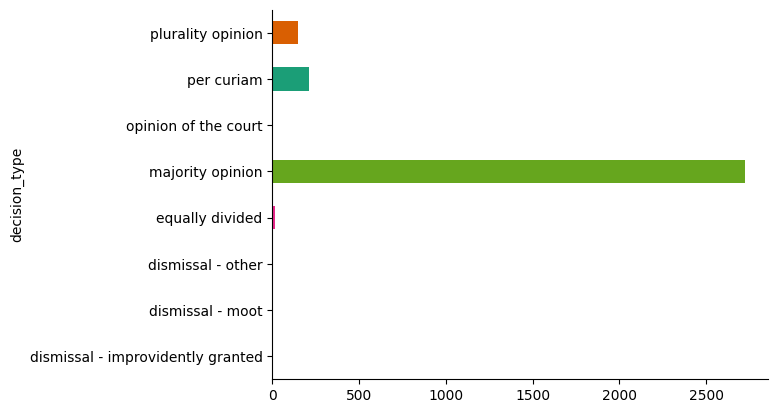

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns
df_concat.groupby('decision_type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [13]:
df_nlp1 = pd.DataFrame(df_nlp, columns=['facts'])

In [14]:
df_nlp1['facts'] = df_nlp1['facts'].str.replace(r'<[^<>]*>', '', regex=True)
df_nlp1

,facts
0,Joan Stanley had three children with Peter Sta...
1,John Giglio was convicted of passing forged mo...
2,"The Idaho Probate Code specified that ""males m..."
3,"Miller, after conducting a mass mailing campai..."
4,Ernest E. Mandel was a Belgian professional jo...
...,...
3093,For over a century after the Alaska Purchase i...
3094,"Refugio Palomar-Santiago, a Mexican national, ..."
3095,Tarahrick Terry pleaded guilty to one count of...
3096,Joshua James Cooley was parked in his pickup t...


In [15]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [16]:
corpus = df_nlp1["facts"]
lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))

In [17]:
ps = nltk.stem.porter.PorterStemmer()
lem = nltk.stem.wordnet.WordNetLemmatizer()

In [18]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [19]:
lst_stopwords = nltk.corpus.stopwords.words("english")

In [20]:
lst_stopwords = nltk.corpus.stopwords.words("english")

In [21]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())

    ## Tokenize (convert from string to list)
    lst_text = text.split()    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in
                    lst_stopwords]

    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]

    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]

    ## back to string from list
    text = " ".join(lst_text)
    return text

In [22]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [23]:
df_nlp1["facts_clean"] = df_nlp1["facts"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))

In [24]:
df_nlp1

,facts,facts_clean
0,Joan Stanley had three children with Peter Sta...,joan stanley three child peter stanley stanley...
1,John Giglio was convicted of passing forged mo...,john giglio convicted passing forged money ord...
2,"The Idaho Probate Code specified that ""males m...",idaho probate code specified male must preferr...
3,"Miller, after conducting a mass mailing campai...",miller conducting mass mailing campaign advert...
4,Ernest E. Mandel was a Belgian professional jo...,ernest e mandel belgian professional journalis...
...,...,...
3093,For over a century after the Alaska Purchase i...,century alaska purchase 1867 federal governmen...
3094,"Refugio Palomar-Santiago, a Mexican national, ...",refugio palomarsantiago mexican national grant...
3095,Tarahrick Terry pleaded guilty to one count of...,tarahrick terry pleaded guilty one count posse...
3096,Joshua James Cooley was parked in his pickup t...,joshua james cooley parked pickup truck side r...


In [25]:
df_nlp2 = pd.concat([df_nlp1,df_target1['first_party_winner']],axis=1, join='inner')

In [26]:
df_nlp2["first_party_winner"].value_counts()

1    2067
0    1031
Name: first_party_winner, dtype: int64

In [27]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

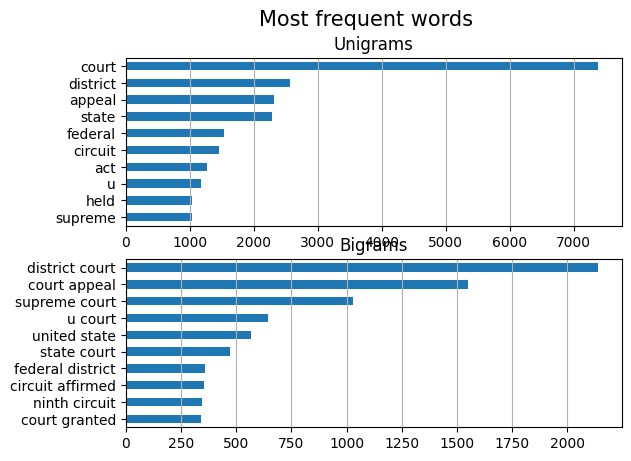

In [28]:
y = 1
corpus = df_nlp2[df_nlp2["first_party_winner"]== y]["facts_clean"]
lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
fig, ax = plt.subplots(nrows=2, ncols=1)
fig.suptitle("Most frequent words", fontsize=15)
#figure(figsize=(30, 24))
## unigrams
dic_words_freq = nltk.FreqDist(lst_tokens)
dtf_uni = pd.DataFrame(dic_words_freq.most_common(),
                       columns=["Word","Freq"])
dtf_uni.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                  kind="barh", title="Unigrams", ax=ax[0],
                  legend=False).grid(axis='x')
ax[0].set(ylabel=None)

## bigrams
dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
dtf_bi = pd.DataFrame(dic_words_freq.most_common(),
                      columns=["Word","Freq"])
dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(
                   string for string in x) )
dtf_bi.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                  kind="barh", title="Bigrams", ax=ax[1],
                  legend=False).grid(axis='x')
ax[1].set(ylabel=None)
plt.show()

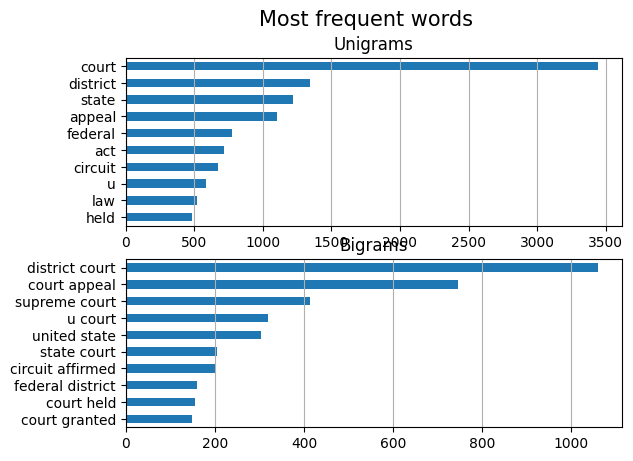

In [29]:
y = 0
corpus = df_nlp2[df_nlp2["first_party_winner"]== y]["facts_clean"]
lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
fig, ax = plt.subplots(nrows=2, ncols=1)
fig.suptitle("Most frequent words", fontsize=15)
#figure(figsize=(30, 24))
## unigrams
dic_words_freq = nltk.FreqDist(lst_tokens)
dtf_uni = pd.DataFrame(dic_words_freq.most_common(),
                       columns=["Word","Freq"])
dtf_uni.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                  kind="barh", title="Unigrams", ax=ax[0],
                  legend=False).grid(axis='x')
ax[0].set(ylabel=None)

## bigrams
dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
dtf_bi = pd.DataFrame(dic_words_freq.most_common(),
                      columns=["Word","Freq"])
dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(
                   string for string in x) )
dtf_bi.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                  kind="barh", title="Bigrams", ax=ax[1],
                  legend=False).grid(axis='x')
ax[1].set(ylabel=None)
plt.show()

In [30]:
import wordcloud

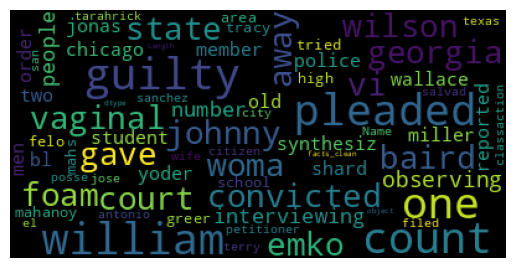

In [31]:
wc = wordcloud.WordCloud(background_color='black', max_words=100,
                         max_font_size=35)
wc = wc.generate(str(corpus))
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.show()

In [32]:
import gensim.downloader as gensim_api
import gensim
import seaborn as sns

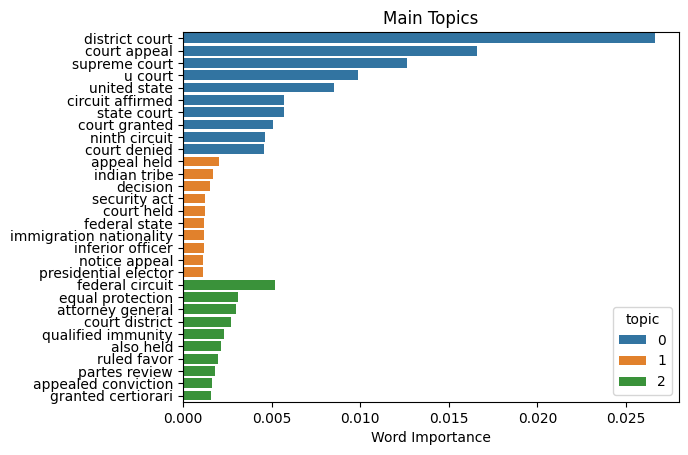

In [33]:
y = 1
corpus = df_nlp2[df_nlp2["first_party_winner"]==y]["facts_clean"]
## pre-process corpus
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i + 2]) for i in range(0,
                     len(lst_words), 2)]
    lst_corpus.append(lst_grams)## map words to an id
id2word = gensim.corpora.Dictionary(lst_corpus)## create dictionary word:freq
dic_corpus = [id2word.doc2bow(word) for word in lst_corpus] ## train LDA
lda_model = gensim.models.ldamodel.LdaModel(corpus=dic_corpus, id2word=id2word, num_topics=7, random_state=123, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

## output
lst_dics = []
for i in range(0,3):
    lst_tuples = lda_model.get_topic_terms(i)
    for tupla in lst_tuples:
        lst_dics.append({"topic":i, "id":tupla[0],
                         "word":id2word[tupla[0]],
                         "weight":tupla[1]})
dtf_topics = pd.DataFrame(lst_dics,
                         columns=['topic','id','word','weight'])

## plot
fig, ax = plt.subplots()
sns.barplot(y="word", x="weight", hue="topic", data=dtf_topics, dodge=False, ax=ax).set_title('Main Topics')
ax.set(ylabel="", xlabel="Word Importance")
plt.show()

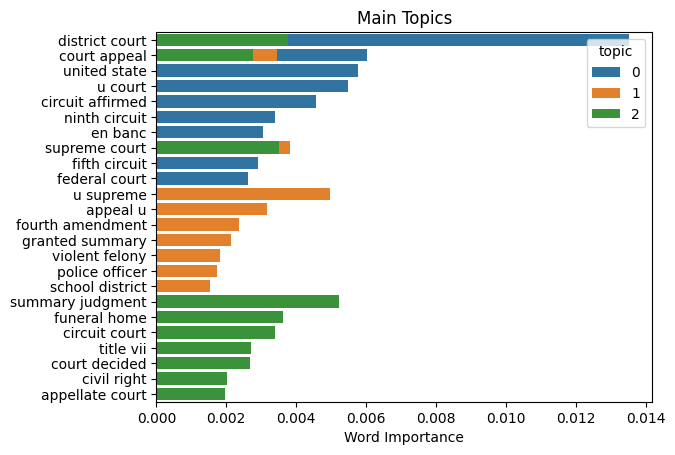

In [34]:
y = 0
corpus = df_nlp2[df_nlp2["first_party_winner"]==y]["facts_clean"]
## pre-process corpus
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i + 2]) for i in range(0,
                     len(lst_words), 2)]
    lst_corpus.append(lst_grams)## map words to an id
id2word = gensim.corpora.Dictionary(lst_corpus)## create dictionary word:freq
dic_corpus = [id2word.doc2bow(word) for word in lst_corpus] ## train LDA
lda_model = gensim.models.ldamodel.LdaModel(corpus=dic_corpus, id2word=id2word, num_topics=7, random_state=123, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

## output
lst_dics = []
for i in range(0,3):
    lst_tuples = lda_model.get_topic_terms(i)
    for tupla in lst_tuples:
        lst_dics.append({"topic":i, "id":tupla[0],
                         "word":id2word[tupla[0]],
                         "weight":tupla[1]})
dtf_topics = pd.DataFrame(lst_dics,
                         columns=['topic','id','word','weight'])

## plot
fig, ax = plt.subplots()
sns.barplot(y="word", x="weight", hue="topic", data=dtf_topics, dodge=False, ax=ax).set_title('Main Topics')
ax.set(ylabel="", xlabel="Word Importance")
plt.show()

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

In [36]:
vectorizer = CountVectorizer()

In [37]:
df_nlp2 = pd.concat([df_nlp1,df_target1['first_party_winner']],axis=1, join='inner')

In [38]:
xfeatures = df_nlp2['facts_clean']
ylabel = df_nlp2['first_party_winner']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(xfeatures,ylabel, test_size=0.25)

In [40]:
pipe = Pipeline(steps=[('cv',CountVectorizer()),('lr',LogisticRegression(solver='liblinear'))])

In [41]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('cv', CountVectorizer()),
                ('lr', LogisticRegression(solver='liblinear'))])

In [42]:
pipe.score(X_test,y_test)

0.6245161290322581

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [44]:
pipe1= Pipeline(steps=[('cv',CountVectorizer()),('rf',RandomForestClassifier())])

In [45]:
pipe1.fit(X_train,y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('rf', RandomForestClassifier())])

In [46]:
pipe1.score(X_train,y_train)

1.0

In [47]:
pipe1.score(X_test,y_test)

0.6412903225806451

In [48]:
pipe2= Pipeline(steps=[('cv',CountVectorizer()),('rf',KNeighborsClassifier(n_neighbors=3))])

In [49]:
pipe2.fit(X_train,y_train)

Pipeline(steps=[('cv', CountVectorizer()),
                ('rf', KNeighborsClassifier(n_neighbors=3))])

In [50]:
pipe2.score(X_train,y_train)

0.8854928971157985

In [51]:
pipe2.score(X_test,y_test)

0.5819354838709677

In [52]:
df_nl1=pd.concat([df_nlp2,df_cat],axis=1,join='inner')

In [53]:
df_nl1

,facts,facts_clean,first_party_winner,decision_type,disposition
0,Joan Stanley had three children with Peter Sta...,joan stanley three child peter stanley stanley...,1,majority opinion,reversed/remanded
1,John Giglio was convicted of passing forged mo...,john giglio convicted passing forged money ord...,1,majority opinion,reversed/remanded
2,"The Idaho Probate Code specified that ""males m...",idaho probate code specified male must preferr...,1,majority opinion,reversed/remanded
3,"Miller, after conducting a mass mailing campai...",miller conducting mass mailing campaign advert...,1,majority opinion,vacated/remanded
4,Ernest E. Mandel was a Belgian professional jo...,ernest e mandel belgian professional journalis...,1,majority opinion,reversed
...,...,...,...,...,...
3093,For over a century after the Alaska Purchase i...,century alaska purchase 1867 federal governmen...,1,majority opinion,reversed/remanded
3094,"Refugio Palomar-Santiago, a Mexican national, ...",refugio palomarsantiago mexican national grant...,1,majority opinion,reversed/remanded
3095,Tarahrick Terry pleaded guilty to one count of...,tarahrick terry pleaded guilty one count posse...,0,majority opinion,affirmed
3096,Joshua James Cooley was parked in his pickup t...,joshua james cooley parked pickup truck side r...,1,majority opinion,vacated/remanded


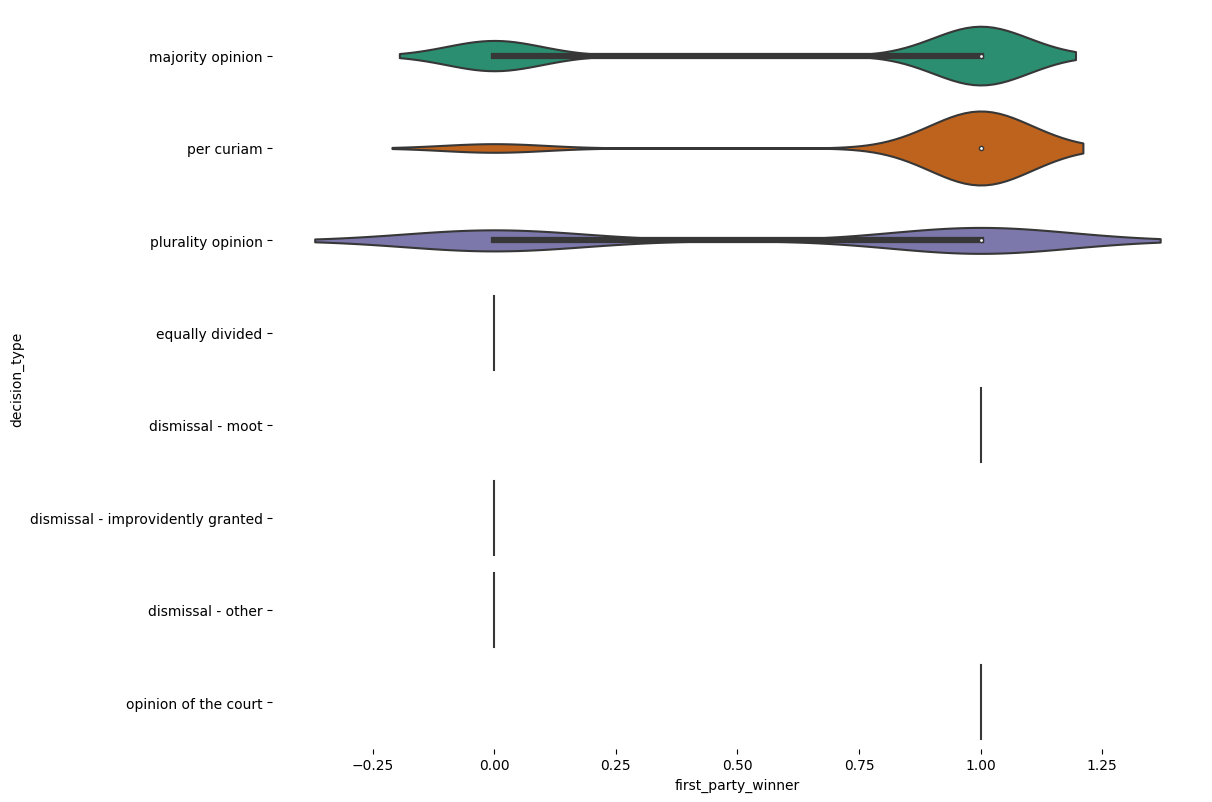

In [54]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_nl1['decision_type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_nl1, x='first_party_winner', y='decision_type', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [55]:
xfeatures1 = df_nl1[['facts_clean','decision_type','disposition']]
ylabel1 = df_nl1['first_party_winner']

In [56]:
df_cat1 = pd.get_dummies(df_cat['decision_type'])

In [57]:
df_cat2 = pd.get_dummies(df_cat['disposition'])

In [58]:
df_cat3=pd.concat([df_cat2,df_cat1],axis=1,join='inner')

In [59]:
df_cat3.columns

Index(['affirmed', 'none', 'reversed', 'reversed in-part',
       'reversed in-part/remanded', 'reversed/remanded', 'vacated',
       'vacated in-part/remanded', 'vacated/remanded',
       'dismissal - improvidently granted', 'dismissal - moot',
       'dismissal - other', 'equally divided', 'majority opinion',
       'opinion of the court', 'per curiam', 'plurality opinion'],
      dtype='object')

In [60]:
df_cat3=pd.concat([df_cat3,df_nl1['first_party_winner']],axis=1,join='inner')

In [61]:
vectorize=CountVectorizer()

In [62]:
count_matrix = vectorize.fit_transform(df_nl1['facts_clean'])
count_array = count_matrix.toarray()
data_final = pd.DataFrame(data=count_array,columns = vectorize.get_feature_names_out())

In [63]:
data_final = pd.concat([data_final,df_cat3],axis=1,join='inner')

In [64]:
data_final

,011119,0125,01657,019,02,036539,04,041352,041581,045323,...,vacated/remanded,dismissal - improvidently granted,dismissal - moot,dismissal - other,equally divided,majority opinion,opinion of the court,per curiam,plurality opinion,first_party_winner
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3093,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3094,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3095,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3096,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1


In [65]:
X_train, X_test, y_train, y_test = train_test_split(data_final.drop(columns=['first_party_winner']),
                                                    data_final['first_party_winner'],
                                                    test_size=0.3,random_state=10)

In [66]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_final = scaler.fit_transform(data_final)

In [67]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=200, random_state=0)
lda_data = lda.fit_transform(X_train)

In [68]:
lda_data_train = pd.DataFrame(data=lda_data)

In [69]:
lda_data_test = pd.DataFrame(data=lda.transform(X_test))


In [70]:
# Create the parameter grid based on the results of random search
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [8,10,12,14],
    'max_features': [60,70,80,90,100],
    'min_samples_leaf': [2, 3, 4],
    'n_estimators': [100, 200, 300]
}# Create a based model
rf = RandomForestClassifier()# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)


In [71]:
#grid_search.fit(lda_data_train, y_train)
#grid_search.best_params_

In [72]:
rand=RandomForestClassifier(max_depth= 8, max_features = 100, min_samples_leaf = 2, n_estimators = 200)

In [73]:
rand.fit(lda_data_train,y_train)

RandomForestClassifier(max_depth=8, max_features=100, min_samples_leaf=2,
                       n_estimators=200)

In [74]:
rand.score(lda_data_train,y_train)

0.7020295202952029

In [75]:
rand.score(lda_data_test,y_test)

0.6741935483870968

In [76]:
from sklearn.metrics import f1_score

In [77]:
y_pred1 = rand.predict(lda_data_test)
f1_score(y_test, y_pred1)

0.8028627195836043

In [78]:
model = XGBClassifier()
model.fit(lda_data_train, y_train)
y_pred = model.predict(lda_data_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
f1_score(y_test, y_pred1)

Accuracy: 66.77%


0.8028627195836043

In [79]:
knn=KNeighborsClassifier(n_neighbors=7)

In [80]:
knn.fit(lda_data_train,y_train)

KNeighborsClassifier(n_neighbors=7)

In [81]:
knn.score(lda_data_train,y_train)

0.7061808118081181

In [82]:
knn.score(lda_data_test,y_test)

0.6365591397849463

In [84]:
# Application of all Machine Learning methods
all_models = []
all_models.append(('LR', LogisticRegression()))
all_models.append(('RFC', RandomForestClassifier()))
all_models.append(('KNN', KNeighborsClassifier()))
all_models.append(('XGB', XGBClassifier()))

In [85]:
all_models

[('LR', LogisticRegression()),
 ('RFC', RandomForestClassifier()),
 ('KNN', KNeighborsClassifier()),
 ('XGB',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=None,
                num_parallel_tree=None, random_state=None, ...))]

In [89]:
models = ['Logistic Regression','Random Forest', 'K Nearest Neighbor','XGBoost']
accuracy = [0.56, 0.80, 0.63, 0.66]  # Accuracy scores

<ipython-input-90-5bbc84a2e471>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


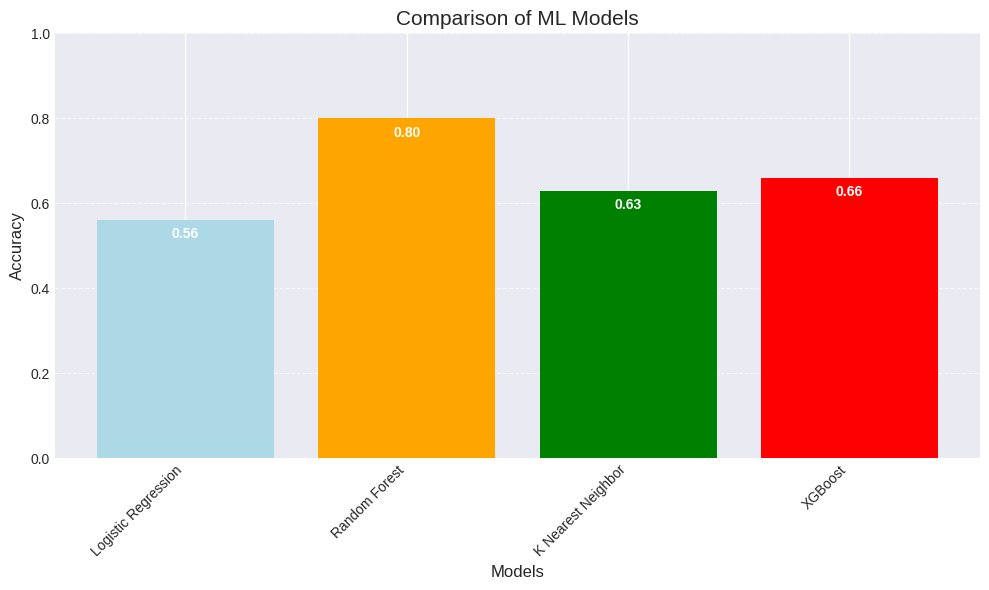

In [90]:
plt.figure(figsize=(10, 6))
plt.style.use('seaborn-darkgrid')
bars = plt.bar(models, accuracy, color=['lightblue', 'orange', 'green', 'red'])
for bar, acc in zip(bars, accuracy):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05, f'{acc:.2f}', ha='center', va='bottom', color='white', fontweight='bold')

plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Comparison of ML Models', fontsize=15)
plt.ylim(0, 1)  # Set the y-axis limit (0 to 1 for accuracy)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x labels for better readability
plt.yticks(fontsize=10)
plt.tight_layout()

# Show the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [91]:
# save the model
import pickle

# save the classification model as a pickle file
model_pkl_file = "supreme_court_judgement_prediction_model.pkl"

with open(model_pkl_file, 'wb') as file:
    pickle.dump(model, file)
print('Model Saved!')

Model Saved!


In [ ]:
'''
# load model from pickle file
with open(model_pkl_file, 'rb') as file:
    model = pickle.load(file)

# evaluate model
y_predict = model.predict(X_test)

# check results
print(classification_report(y_test, y_predict))
'''

"\n# load model from pickle file\nwith open(model_pkl_file, 'rb') as file:  \n    model = pickle.load(file)\n\n# evaluate model \ny_predict = model.predict(X_test)\n\n# check results\nprint(classification_report(y_test, y_predict)) \n"